# MA-MACD Strategy Evaluation

In the MA-MACD strategy, we will explore adding a Moving-Average Convergence Divergence (MACD) filter on top of the Moving Average filter (MA). The MACD is a technical momentum indicator which is used to identify market trends.

## MACD 
To understand the MACD indicator itself, there are three main parameters that are used namely: `fastperiod`, `slowperiod`, and `signalperiod`. The MACD Proper series is created by subtracting the values of the MA slowperiod from the MA fastperiod, where : 
- MA "fastperiod": EMA (Exponential Moving Average) of stock price using `fastperiod`
- MA "slowperiod": EMA of stock price using `slowperiod`

Thereafter, we create a MACD signal series which is based on an EMA of MACD Proper using the `signalperiod`. 

Using both the MACD Proper series and the MACD signal series, one can obtain the MACD histogram by subtracting the MACD signal series from the MACD Proper series. The MACD Histogram is a measure of market momentum; when it is positive, it represents upward market momentum trends and vice versa.

There are some MACD combinations that are commonly used by traders. For this Capstone, we explored the following MACD combinations:
- MACD (12, 26, 9): Fast period = 12, Slow = 26, Signal = 9
- MACD (8, 17, 9): Fast period = 8, Slow = 17, Signal = 9
- MACD (5, 35, 5): Fast period = 5, Slow = 35, Signal = 5

When we refer to the MA-MACD strategy, it is actually a four layered composite strategy as illustrated by the table below. By applying all filters jointly, we obtain refined filtered trading signals.

|MA-MACD composite strategy|
|-|
|Filter 1 (Trades with correct Oscillator polarity)|
|Filter 2 (Trades with Oscillator value between -7 to 7)|
|MA|
|MACD|

For MA-MACD evaluation, we will be exploring different combinations of the following:
- MA(X/13) where X is an intraday interval
- MACD(12,26,9) or MACD(8,17,9) or MACD(5,35,5)

Example: "MA(10/13)_MACD(12,26,9)", where we add on a MACD (12, 26, 9) layer on top of the MA (10/13) layer to filter out signals

For the MA-MACD filter, it obtains trade signals that are aligned with the market trend:
- For Buy actions, the market is in upward trend as represented by positive MA slope values and positive MACD histogram values
- For Sell actions, the market is in downward trend as represented by negative MA slope values and negative MACD histogram values

There are custom functions located in a separate python script `ma_macd_calculation.py` that calculate the annualised return metric:
- __filter_signals_MA_MACD__: For a given strategy combination, it generates the filtered signals across 21 years for 1 stock.
- __portfolio_eval_ma_macd__: For a given strategy combination, it compiles all filtered signals for all stocks to calculate the yearly breakdown of the annualised return metric for a particular strategy.
- __strategy_eval_ma_macd__: It compiles all yearly breakdowns of the annualised return metric for all strategy combinations that are explored.

In [2]:
from ma_macd_calculation import filter_signals_MA_MACD, portfolio_eval_ma_macd, strategy_eval_ma_macd

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import talib as ta
from os import listdir
from os.path import isfile, join
import pickle

from tqdm import tqdm
# Remove settingwithcopy warning
pd.options.mode.chained_assignment = None  

In [3]:
# MACD params
macd_params_dict = {}
macd_params_dict[0] = {"mfast":12, "mslow":26, "msignal":9}
macd_params_dict[1] = {"mfast":8, "mslow":17, "msignal":9}
macd_params_dict[2] = {"mfast":5, "mslow":35, "msignal":5}

# directory paths
data_directory_path = "../../data/2020/"

Due to the nature of the MA-MACD parameter combinations, the number of parameter combinations can be very large since we are exploring intra-day intervals for the MA, but also with 3 MACD combinations. 
- Prior to the creation of this notebook, we explored 260 intraday intervals with 3 MACD combinations, which resulted in 780 strategy evaluations (which took a long time).

Accounting for that, __we will first visualise the previous metric results__, and __replicate the strategy evaluation search over a reduced parameter space/range where the highest annualised return metric is observed__.

In [4]:
# Load Buy df from previous evaluations
with open('../../archived/quickstart/ma_macd_optimisation/buy_df.pickle', 'rb') as handle:
     large_buy_df = pickle.load(handle)

# Load Sell df from previous evaluations
with open('../../archived/quickstart/ma_macd_optimisation/sell_df.pickle', 'rb') as handle:
     large_sell_df = pickle.load(handle)

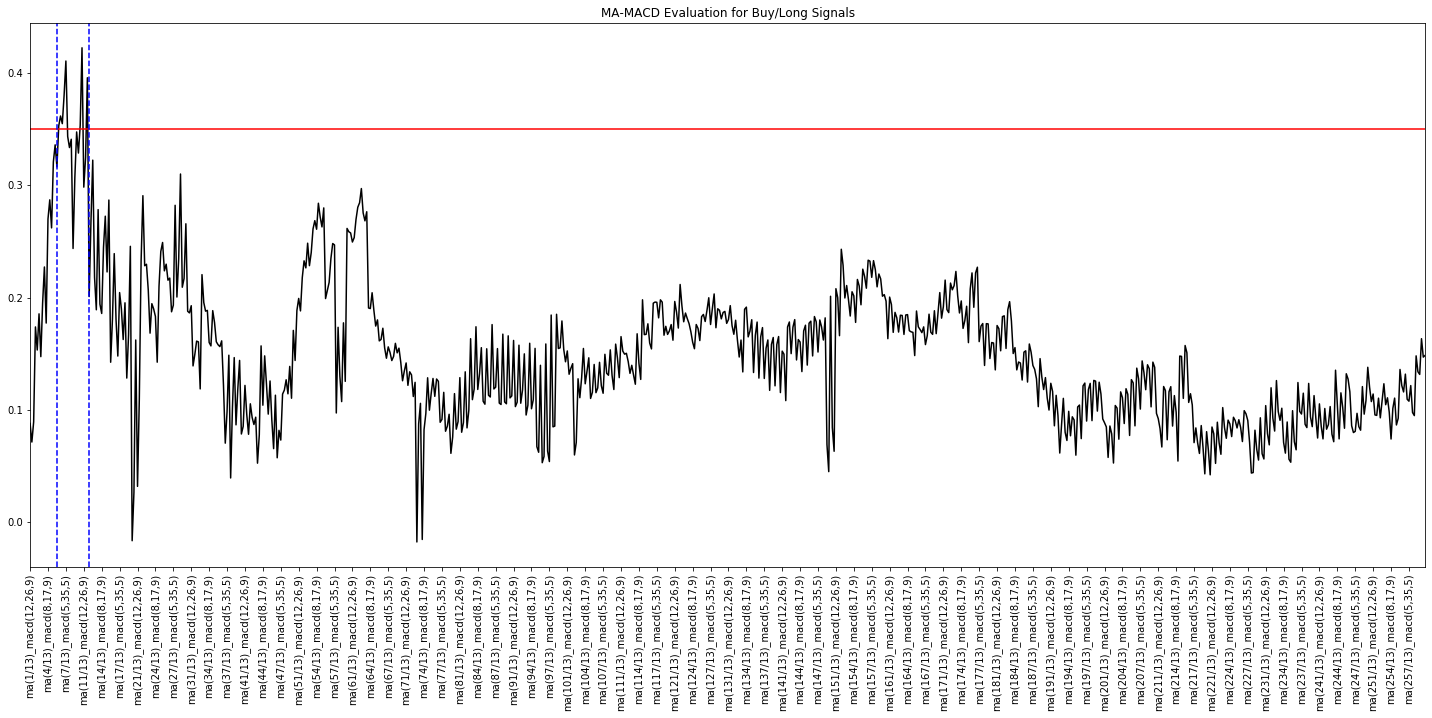

In [8]:
plt.figure(figsize=(25,10))
large_buy_df.mean().plot(color = "black")
plt.xticks(np.arange(0,780,10), large_buy_df.columns[0:780:10], rotation = 90)
plt.title("MA-MACD Evaluation for Buy/Long Signals")

plt.axhline(y = 0.35, color = "r")
plt.axvline(x = 5 * 3, color = "blue", linestyle = "--")
plt.axvline(x = 11* 3, color = "blue", linestyle = "--")

In [9]:
print("Lower bound for param space for Buy signals is '{}'".format(large_buy_df.columns[5*3]))
print("Upper bound for param space for Buy signals is '{}'".format(large_buy_df.columns[11*3]))

Lower bound for param space for Buy signals is 'ma(6/13)_macd(12,26,9)'
Upper bound for param space for Buy signals is 'ma(12/13)_macd(12,26,9)'


We observe that the __best intraday window parameter for MA-MACD for Buy signals is__:
- higher than 6 intraday intervals 
- lower than 12 intraday intervals

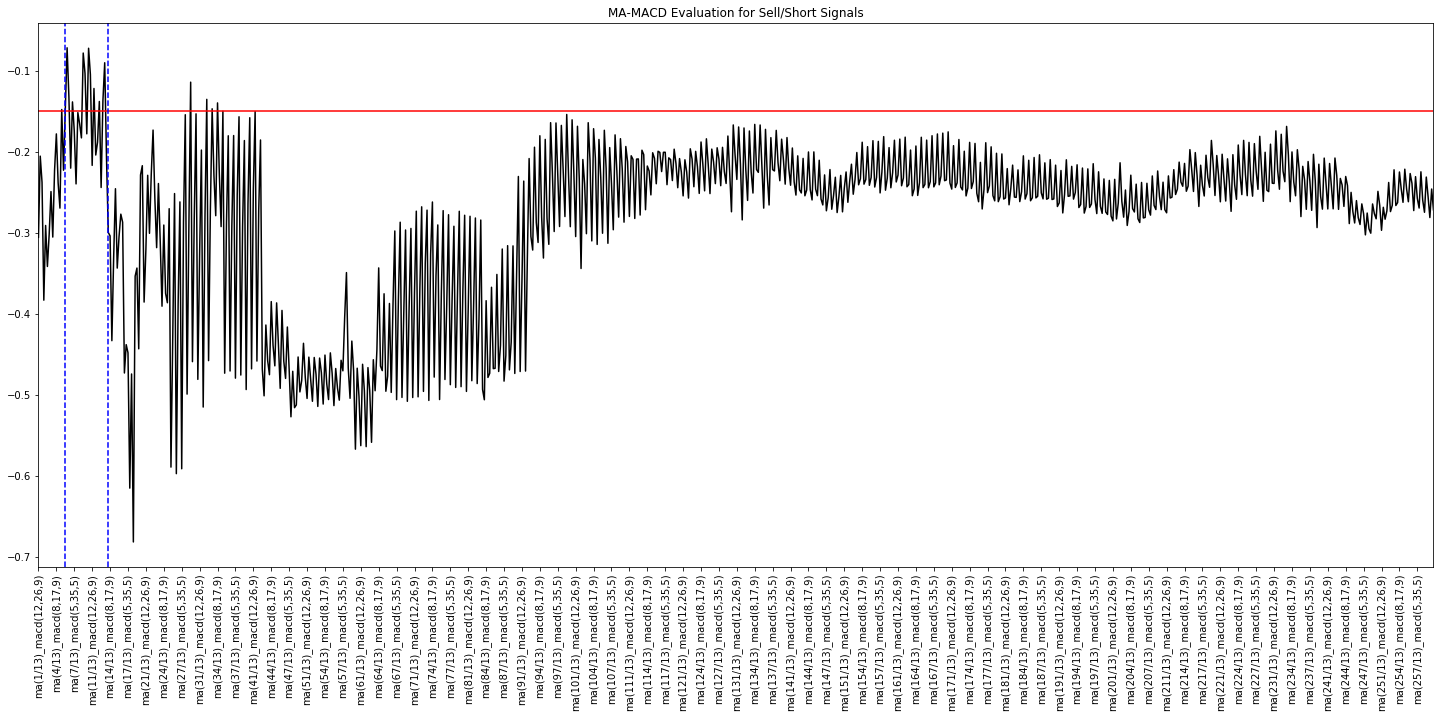

In [10]:
plt.figure(figsize=(25,10))
large_sell_df.mean().plot(color = "black")
plt.xticks(np.arange(0,780,10), large_sell_df.columns[0:780:10], rotation = 90)
plt.title("MA-MACD Evaluation for Sell/Short Signals")

plt.axhline(y = -0.15, color = "r")
plt.axvline(x = 5 * 3, color = "blue", linestyle = "--")
plt.axvline(x = 13* 3, color = "blue", linestyle = "--")

In [11]:
print("Lower bound for reduced param space for Sell signals is '{}'".format(large_buy_df.columns[5*3]))
print("Upper bound for reduced param space for Sell signals is '{}'".format(large_buy_df.columns[13*3]))

Lower bound for reduced param space for Sell signals is 'ma(6/13)_macd(12,26,9)'
Upper bound for reduced param space for Sell signals is 'ma(14/13)_macd(12,26,9)'


We observe that the __best intraday window parameter for MA-MACD for Sell signals is__:
- higher than 6 intraday intervals 
- lower than 14 intraday intervals

## Reduced Strategy Param Space Evaluation
Using the reduced parameter search space, we will calculate the __yearly breakdown of the annualised metric return__ for Buy and Sell signals separately.

In [12]:
# Buy MA Window intervals
buy_ma_window_list = [i for i  in range(6,12)]

# Sell MA Window intervals
sell_ma_window_list = [i for i in range(6,14)]

In [13]:
# "Buy"
buy_df = strategy_eval_ma_macd("buy_only", data_directory_path, buy_ma_window_list, macd_params_dict)

100%|██████████| 6/6 [08:51<00:00, 88.65s/it]


In [14]:
# "Sell"
sell_df = strategy_eval_ma_macd("sell_only", data_directory_path, buy_ma_window_list, macd_params_dict)

100%|██████████| 6/6 [09:45<00:00, 97.67s/it]


In [15]:
buy_df

,"ma(6/13)_macd(12,26,9)","ma(6/13)_macd(8,17,9)","ma(6/13)_macd(5,35,5)","ma(7/13)_macd(12,26,9)","ma(7/13)_macd(8,17,9)","ma(7/13)_macd(5,35,5)","ma(8/13)_macd(12,26,9)","ma(8/13)_macd(8,17,9)","ma(8/13)_macd(5,35,5)","ma(9/13)_macd(12,26,9)","ma(9/13)_macd(8,17,9)","ma(9/13)_macd(5,35,5)","ma(10/13)_macd(12,26,9)","ma(10/13)_macd(8,17,9)","ma(10/13)_macd(5,35,5)","ma(11/13)_macd(12,26,9)","ma(11/13)_macd(8,17,9)","ma(11/13)_macd(5,35,5)"
year,,,,,,,,,,,,,,,,,,
2000,-1.132606,-0.635201,0.310330,-0.447534,-0.127345,1.151112,-0.286506,-0.099697,0.754798,-0.406630,-0.575312,0.171505,-1.103358,-0.543096,0.592585,-0.923471,-0.671613,0.876165
2001,1.032504,1.215716,1.084323,0.658542,1.121537,1.274708,0.440855,0.696144,0.807216,0.617763,0.871755,0.897177,0.038401,0.527190,0.543886,-0.029050,0.557904,0.376141
2002,-0.334313,-0.022655,0.066417,-0.287981,-0.067611,0.065860,-0.157488,0.013422,0.050767,-0.019476,0.294992,0.360392,-0.039824,0.196035,0.481178,0.247427,0.554920,0.745100
2003,0.735093,0.733400,0.847736,0.736138,0.685103,0.869157,0.846472,0.899940,1.067404,0.846174,0.671158,0.752715,0.686682,0.554539,0.599916,0.999888,0.936345,0.953635
2004,-0.021211,0.010895,0.080922,0.009083,0.005221,0.104761,-0.097222,-0.137089,-0.101900,-0.075552,-0.108214,-0.040375,0.430704,0.351056,0.518141,0.374215,0.239142,0.432835
2005,0.256148,-0.008805,0.109296,0.343617,0.086948,0.057761,0.311991,-0.156457,-0.055508,0.347741,0.198895,0.208591,0.418063,-0.101241,0.106581,0.227098,-0.153106,0.138855
2006,0.208509,0.138913,0.165818,0.261066,0.131704,0.198494,0.179512,0.043158,0.117447,0.032876,0.041645,0.114641,0.032617,-0.074793,-0.013998,0.124342,0.046248,0.062233
2007,-0.135316,0.018332,-0.059142,-0.136935,-0.012270,-0.119734,-0.061205,-0.005281,-0.106288,0.137437,0.255527,0.209493,0.172788,0.129246,0.070767,0.147979,0.082556,0.072980
2008,0.516875,0.236844,0.360085,0.379595,0.170427,0.357214,0.368113,0.072040,0.178585,0.233775,-0.137440,0.041302,0.476057,0.084094,0.217555,0.596002,0.173019,0.263983


In [16]:
sell_df

,"ma(6/13)_macd(12,26,9)","ma(6/13)_macd(8,17,9)","ma(6/13)_macd(5,35,5)","ma(7/13)_macd(12,26,9)","ma(7/13)_macd(8,17,9)","ma(7/13)_macd(5,35,5)","ma(8/13)_macd(12,26,9)","ma(8/13)_macd(8,17,9)","ma(8/13)_macd(5,35,5)","ma(9/13)_macd(12,26,9)","ma(9/13)_macd(8,17,9)","ma(9/13)_macd(5,35,5)","ma(10/13)_macd(12,26,9)","ma(10/13)_macd(8,17,9)","ma(10/13)_macd(5,35,5)","ma(11/13)_macd(12,26,9)","ma(11/13)_macd(8,17,9)","ma(11/13)_macd(5,35,5)"
year,,,,,,,,,,,,,,,,,,
2000,0.409658,1.107262,0.310598,-0.038047,0.815704,0.401464,-0.309227,0.534970,0.806618,-0.438701,0.572059,0.911590,-0.247380,1.204567,0.913081,-0.936526,0.310426,-0.588087
2001,-0.438311,-0.234830,-0.500351,-0.586860,-0.297321,-0.603482,0.092752,0.417019,0.159894,0.346782,0.542713,0.247899,0.155006,0.345315,-0.030312,0.046050,0.237415,-0.101118
2002,0.151630,0.089886,0.057691,0.030446,-0.061156,-0.036298,0.074405,-0.163756,-0.201328,0.430303,0.190552,0.076803,0.172272,-0.027056,-0.081679,0.022810,-0.072648,-0.230098
2003,-0.196009,-0.340053,-0.351708,-0.421752,-0.623048,-0.536610,-0.620644,-0.807457,-0.710773,-0.272030,-0.504488,-0.437686,-0.624796,-0.854816,-0.755777,-0.464350,-0.635996,-0.477518
2004,-1.124141,-0.996271,-1.096474,-0.988490,-0.748893,-0.884281,-0.736622,-0.485904,-0.548454,-0.614591,-0.425184,-0.468773,-0.807972,-0.705463,-0.607539,-0.924031,-0.612136,-0.818079
2005,-0.050377,-0.030340,-0.122949,0.089835,0.085247,-0.049477,-0.061103,-0.125241,-0.140828,-0.635972,-0.701177,-0.577310,-0.749807,-0.804985,-0.663782,-0.659720,-0.805933,-0.749231
2006,-0.292116,-0.350512,-0.377006,-0.494632,-0.574747,-0.542670,-0.441719,-0.413991,-0.364504,-0.170259,-0.350155,-0.329896,-0.169360,-0.434435,-0.329841,-0.153755,-0.440381,-0.325755
2007,-0.266926,-0.171058,-0.278472,-0.304534,-0.162190,-0.304895,-0.315646,-0.152610,-0.284027,-0.227431,-0.087254,-0.245726,-0.283477,-0.197608,-0.308330,-0.273243,-0.161104,-0.238543
2008,1.086105,0.819421,0.807271,1.008761,0.607917,0.539538,0.797535,0.417374,0.338136,0.824157,0.477866,0.528107,1.260478,1.223866,1.146416,0.708651,0.593006,0.551465


Based on the calculation across the different MA-MACD strategy parameters combinations, we can find the best strategy as defined by the average annualised metric performance across 21 years. Thereafter we can obtain relevant statistics about the strategy's performance such as:
- Average annualised return metric
- Standard deviation of the annualised return metric across 21 years
- Average annualised return per unit of standard deviation risk (reward-to-risk)
- Filter trade signal counts
- Average portfolio cumulative return (based on equal stock weightage)
- Average holding time in days per trade signal

In [17]:
from ma_macd_calculation import get_stats

In [18]:
top_buy_stats = get_stats(buy_df, "buy_only", data_directory_path)
top_buy_stats.index = [str(top_buy_stats.index[0]).upper()]

top_sell_stats = get_stats(sell_df, "sell_only", data_directory_path)
top_sell_stats.index = [str(top_sell_stats.index[0]).upper()]

100%|██████████| 1/1 [00:31<00:00, 31.32s/it]


In [19]:
top_buy_stats

,avg_metric,std_metric,avg_metric/std_metric,filter_counts,avg_port_cum_return,avg_holding_time_per_signal
"MA(10/13)_MACD(5,35,5)",0.422497,0.543531,0.777317,20724.0,1.565296,0.874062


In [22]:
top_sell_stats

,avg_metric,std_metric,avg_metric/std_metric,filter_counts,avg_port_cum_return,avg_holding_time_per_signal
"MA(6/13)_MACD(8,17,9)",-0.071631,0.470364,-0.152288,30105.0,0.853266,0.947342


In [23]:
# Output to csvs
top_buy_stats.to_csv("../Output_strategy_statistics/ma_macd_buy.csv")

top_sell_stats.to_csv("../Output_strategy_statistics/ma_macd_sell.csv")

In [18]:
top_buy_stats = pd.read_csv("../Output_strategy_statistics/ma_macd_buy.csv", index_col = 0)
top_buy_stats.index = [str(top_buy_stats.index[0]).upper()]
top_buy_stats

,avg_metric,std_metric,avg_metric/std_metric,filter_counts,avg_port_cum_return,avg_holding_time_per_signal
"MA(10/13)_MACD(5,35,5)",0.422497,0.543531,0.777317,20724.0,1.565296,0.874062


In [15]:
str(top_buy_stats.index[0]).upper()

'MA(10/13)_MACD(5,35,5)'

In [21]:
top_sell_stats = pd.read_csv("../Output_strategy_statistics/ma_macd_sell.csv", index_col = 0)
top_sell_stats.index = [str(top_sell_stats.index[0]).upper()]
top_sell_stats

,avg_metric,std_metric,avg_metric/std_metric,filter_counts,avg_port_cum_return,avg_holding_time_per_signal
"MA(6/13)_MACD(8,17,9)",-0.071631,0.470364,-0.152288,30105.0,0.853266,0.947342
